In [1]:
from dataclasses import dataclass, field
from typing import Optional, Any, Dict, List

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Загрузим датасет, уберем айди студента и изменим поле оценки

In [2]:
data = pd.read_csv("student_petf.csv")
data = data.iloc[:, 1:]

data["GRADE"] = data["GRADE"].apply(lambda x: 0 if x <= 3 else 1)
total_features = data.shape[1]
n_select = int(np.sqrt(total_features) + 1)
selected_features = np.random.choice(data.columns, n_select, replace=False)
selected_data_with_grades = data[selected_features].copy()
selected_data_with_grades['GRADE'] = data['GRADE']
data = selected_data_with_grades

data

,COURSE ID,GRADE,C20,C22,C2,C18
0,1,0,1,1,2,2
1,1,0,1,1,2,2
2,1,0,1,1,2,1
3,1,0,1,1,1,1
4,1,0,1,1,2,1
...,...,...,...,...,...,...
140,9,1,1,1,1,3
141,9,1,2,2,1,2
142,9,0,1,1,1,2
143,9,1,1,1,1,2


In [3]:
@dataclass
class Node:
    feature: Optional[str] = None
    value: Optional[Any] = None
    is_leaf: bool = False
    prediction: Optional[Any] = None
    class_counts: Optional[Dict[Any, int]] = None 
    children: Dict[Any, 'Node'] = field(default_factory=lambda: {})
    
    def add_child(self, value: Any, child_node: 'Node') -> None:
        self.children[value] = child_node


In [4]:
class C45:
    def __init__(self, data: pd.DataFrame, target_col: str):
        self.data = data
        self.target_col = target_col
        self.features = list(data.columns.drop(target_col))
    
    def _entropy(self, target_col: pd.Series) -> float:
        # Энтропия Шеннона
        elements, counts = np.unique(target_col, return_counts=True)
        entropy = 0.0
        for count in counts:
            prob = count / np.sum(counts)
            entropy -= prob * np.log2(prob)
        return entropy

    def _info(self, split_attr: str) -> float:
        # Прирост информации
        total_entropy = self._entropy(self.data[self.target_col])
        vals, counts = np.unique(self.data[split_attr], return_counts=True)
        
        weighted_entropy = 0.0
        for i, val in enumerate(vals):
            subset = self.data[self.data[split_attr] == val]
            prob = counts[i] / np.sum(counts)
            weighted_entropy += prob * self._entropy(subset[self.target_col])
        return total_entropy - weighted_entropy
    
    
    def _build_tree(self,
                   data: pd.DataFrame,
                   parent_node: Optional[Any],
                   features: List[str]) -> Node:
        class_counts = dict(zip(*np.unique(data[self.target_col], return_counts=True)))

        if len(np.unique(data[self.target_col])) == 1:
            return Node(is_leaf=True, prediction=np.unique(data[self.target_col])[0], class_counts=class_counts)

        if len(data) == 0:
            common_class = np.unique(self.data[self.target_col])[
                np.argmax(np.unique(self.data[self.target_col], return_counts=True)[1])
            ]
            return Node(is_leaf=True, prediction=common_class, class_counts=class_counts)
        
        parent_node_сlass = np.unique(self.data[self.target_col])[
            np.argmax(np.unique(self.data[self.target_col], return_counts=True)[1])
        ]
        if len(features) == 0:
            return Node(is_leaf=True, prediction=parent_node_сlass, class_counts=class_counts)
        item_values = [
            self._info(feature) for feature in features
        ]
        best_feature_index = int(np.argmax(item_values))
        best_feature = features[best_feature_index]
        root = Node(feature=best_feature, class_counts=class_counts)
        
        remaining_features = [feature for feature in features if feature != best_feature]
        
        for value in np.unique(data[best_feature]):
            subset = data[data[best_feature] == value]
            child_node = self._build_tree(subset, parent_node_сlass, remaining_features)
            root.add_child(value, child_node)
        
        return root
    
    def fit(self):
        return self._build_tree(self.data, None, self.features)
    
    def predict_one(self, node: Node, row: pd.Series) -> Any:
        if node.is_leaf:
            return node.prediction
        value = row[node.feature]
        if value in node.children:
            return self.predict_one(node.children[value], row)
        else:
            return 0.5

    def predict(self, node: Node, data: pd.DataFrame) -> List[Any]:
        return [self.predict_one(node, row) for _, row in data.iterrows()]

    def predict_proba_one(self, node: Node, row: pd.Series) -> Dict[Any, float]:
        if node.is_leaf:
            total = sum(node.class_counts.values())
            return {cls: count / total for cls, count in node.class_counts.items()}
        
        value = row[node.feature]
        if value in node.children:
            return self.predict_proba_one(node.children[value], row)
        else:
            total = sum(node.class_counts.values())
            return {cls: count / total for cls, count in node.class_counts.items()}

    def predict_proba(self, node: Node, data: pd.DataFrame) -> List[Dict[Any, float]]:
        return [self.predict_proba_one(node, row) for _, row in data.iterrows()]

    def print_tree(self, node: Node, indent: str = "") -> None:
        if node.is_leaf:
            print(f"{indent}Predict: {node.prediction}")
        else:
            for value, child in node.children.items():
                print(f"{indent}[{node.feature} = {value}]")
                self.print_tree(child, indent + "\t")
        


In [5]:
def train_test_split(data, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    indices = np.random.permutation(data.index)
    test_count = int(test_size * len(data))
    test_indices = indices[:test_count]
    train_indices = indices[test_count:]
    train = data.loc[train_indices].reset_index(drop=True)
    test = data.loc[test_indices].reset_index(drop=True)
    return train, test

data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

tree = C45(data_train, "GRADE")
root = tree.fit()
tree.print_tree(root)

[COURSE ID = 1]
	[C2 = 1]
		[C18 = 1]
			Predict: 0
		[C18 = 2]
			[C20 = 1]
				[C22 = 1]
					Predict: 0
				[C22 = 2]
					Predict: 0
	[C2 = 2]
		[C18 = 1]
			[C20 = 1]
				[C22 = 1]
					Predict: 0
				[C22 = 2]
					Predict: 0
		[C18 = 2]
			[C20 = 1]
				[C22 = 1]
					Predict: 0
				[C22 = 2]
					Predict: 0
			[C20 = 2]
				[C22 = 1]
					Predict: 0
				[C22 = 2]
					Predict: 0
		[C18 = 3]
			[C20 = 1]
				[C22 = 1]
					Predict: 0
[COURSE ID = 2]
	Predict: 0
[COURSE ID = 3]
	Predict: 1
[COURSE ID = 4]
	[C2 = 2]
		[C18 = 2]
			[C20 = 1]
				Predict: 0
			[C20 = 2]
				Predict: 1
[COURSE ID = 5]
	[C2 = 1]
		Predict: 1
	[C2 = 2]
		[C18 = 1]
			Predict: 1
		[C18 = 2]
			[C20 = 1]
				[C22 = 1]
					Predict: 0
[COURSE ID = 6]
	Predict: 1
[COURSE ID = 7]
	[C2 = 1]
		[C18 = 2]
			[C20 = 1]
				[C22 = 1]
					Predict: 0
	[C2 = 2]
		Predict: 1
[COURSE ID = 8]
	Predict: 0
[COURSE ID = 9]
	[C2 = 1]
		[C18 = 1]
			[C20 = 1]
				Predict: 0
			[C20 = 2]
				[C22 = 1]
					Predict: 0
				[C

In [6]:
y_pred = tree.predict(root, data_test)

In [7]:
def rates(y_true, y_predicted):
    tp, fp, tn, fn = 0, 0, 0, 0
    for true_label, pred_label in zip(y_true, y_predicted):
        if true_label == pred_label:
            if true_label == 1: tp += 1
            else: tn += 1
        else:
            if true_label == 1: fp += 1
            else: fn += 1
    return tp, fp, tn, fn

def evaluate(y_true: List[Any], y_predicted: List[Any]) -> tuple[float, float, float]:
    tp, fp, tn, fn = rates(y_true, y_predicted)
    accuracy = (tp + fp) / len(y_true) 
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return accuracy, precision, recall

In [8]:
accuracy, precision, recall = evaluate(data_test["GRADE"], y_pred)
print(f"{accuracy=:.3}")
print(f"{precision=:.3}")
print(f"{recall=:.3}")

accuracy=0.414
precision=0.417
recall=0.714


In [9]:
y_pred_proba = tree.predict_proba(root, data_test)
prob_positive = [prob[1] if 1 in prob else 0 for prob in y_pred_proba]

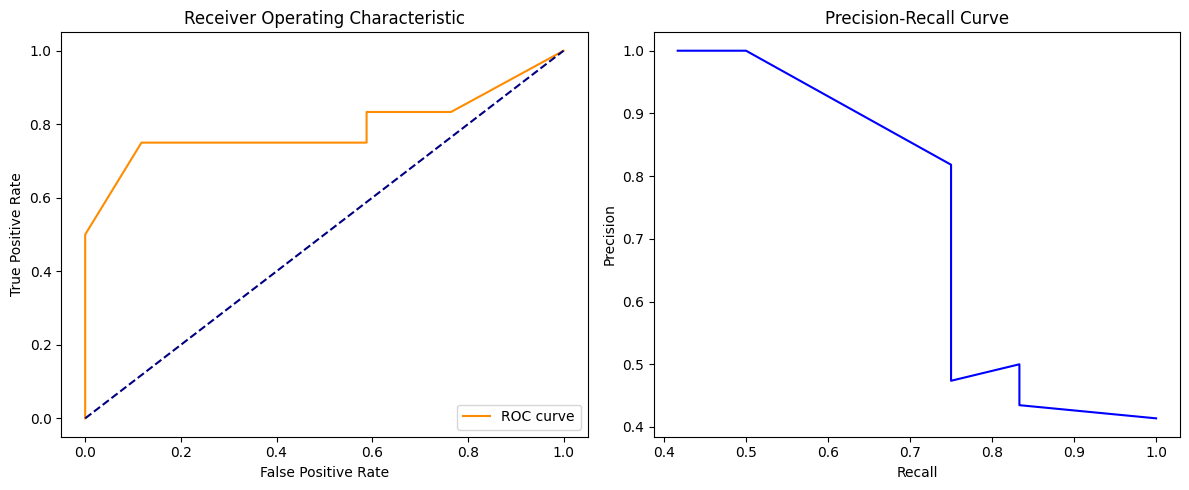

In [10]:
def calculate_roc_pr_curves(predictions, true_labels):
   thresholds = np.linspace(0, 1, num=100)
   tpr_list = []
   fpr_list = []
   precision_list = []
   recall_list = []

   for threshold in thresholds:
       binary_predictions = (predictions >= threshold).astype(int)
       
       tp = np.sum((binary_predictions == 1) & (true_labels == 1))
       fp = np.sum((binary_predictions == 1) & (true_labels == 0))
       tn = np.sum((binary_predictions == 0) & (true_labels == 0))
       fn = np.sum((binary_predictions == 0) & (true_labels == 1))
       
       tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
       fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
       tpr_list.append(tpr)
       fpr_list.append(fpr)
       
       precision = tp / (tp + fp) if (tp + fp) != 0 else 0
       recall = tp / (tp + fn) if (tp + fn) != 0 else 0
       precision_list.append(precision)
       recall_list.append(recall)
   tpr_list.append(0)
   fpr_list.append(0)
   return np.array(fpr_list), np.array(tpr_list), np.array(precision_list), np.array(recall_list)

fpr, tpr, precision, recall = calculate_roc_pr_curves(np.array(prob_positive), data_test["GRADE"])
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='b', label='PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()